# Table of Contents
* [1. Objectives and goals](#1.-Objectives-and-goals)
	* [1.1 Problem statement](#1.1-Problem-statement)
* [2. Training BioNER](#2.-Training-BioNER)
	* [2.1 Dataset](#2.1-Dataset)
	* [2.2 Attributes and features extraction](#2.2-Attributes-and-features-extraction)
	* [2.3 Models and optimization options](#2.3-Models-and-optimization-options)
* [3. Trained model evaluation](#3.-Trained-model-evaluation)
* [4. Using BioNER tagger (i.e. trained model)](#4.-Using-BioNER-tagger-%28i.e.-trained-model%29)
	* [4.1 Reviving trained model (BioNER)](#4.1-Reviving-trained-model-%28BioNER%29)
	* [4.2 Decoding method](#4.2-Decoding-method)
* [5. Literature and references](#5.-Literature-and-references)


In [1]:
# first we define relevant directories
import sys
# in case PySeqLab package is not installed, 
# we can download the package repository from https://bitbucket.org/A_2/pyseqlab
# and then we add the location of the repository to the python system path
# location of the PySeqLab repository on disk -- INSERT location or discard if PySeqLab package is already installed
pyseqlab_package_dir = ""
sys.path.insert(0, pyseqlab_package_dir)
import os
# project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# src directory for the project repository
src_dir = os.path.join(project_dir, 'src')
sys.path.insert(0, src_dir)
# get the tutorials dir
tutorials_dir = os.path.join(project_dir, 'tutorials')
# to use for customizing the display/format of the cells
from IPython.core.display import HTML
with open(os.path.join(tutorials_dir, 'pseqlab_base.css')) as f:
    css = "".join(f.readlines())
HTML(css)


In [2]:
from train_bioner_workflow import *

# 1. Objectives and goals

In this tutorial, we will learn about:
<ul>
<li> the process/workflow for building biomedical named entity recognizer <code class="pseq_code">BioNER</code> (i.e. based on CRFs model formalism)</li>
<li> training the built model and evaluating its performance</li>
<li> reviving the trained model and decoding new sequences (i.e. test sequences that were not used for training)</li>
</ul>

## 1.1 Problem statement

The Bio-Entity Recognition task (Bio-NER) (Kim et al., 2004) is based on the GENIA corpus version 3.02 that aimed at identifying and classifying technical terms in the domain of molecular biology (<a href="http://www.nactem.ac.uk/tsujii/GENIA/ERtask/report.html">BioNLP/NLPBA 2004 task</a>).

<blockquote>Given a set of sentences extracted from medical abstracts, the goal is to identify 5 classes representing the targeted biomedical entities Protein, DNA, RNA, Cell line and Cell type.</blockquote>

<strong><em>Reminder</em></strong>: To work with this tutorial interactively, we need to clone the <a href="https://bitbucket.org/A_2/bio-entity-recognition">bio-entity-recognition repository from bitbucket</a> to our disk locally. Then, navigate to <strong>[cloned_package_dir]/tutorials</strong> where <strong>[cloned_package_dir]</strong> is the path to the cloned package folder. 

<strong><span style="color:red;">NB: </span></strong> <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> should be already installed or included in the python system path before we proceed.

# 2. Training BioNER

The <code class="pseq_code">src</code> directory in the cloned repository includes two main modules: 
<ul>
<li><code class="pseq_code">train_bioner_workflow.py </code></li>
<li><code class="pseq_code">bioner_extractor.py </code></li>
</ul>

As a prerequisite, refer to <a href="http://pyseqlab.readthedocs.io/en/latest/methods_tutorials.html">the tutorials</a> describing in detail the model building and training process using PySeqLab package.

## 2.1 Dataset

Originally, the dataset is composed of two files found in the <code class="pseq_code">dataset</code> folder (see the printed tree path below):
<ol>
<li>training file (<code class="pseq_code">Genia4ERtask1.iob2</code>)</li>
<li>testing file (<code class="pseq_code">Genia4EReval1.iob2</code>)</li>
</ol>

<pre style="font-size:0.8em">
├── dataset
│   ├── original
│   │   ├── training
│   │   │   ├── Genia4ERtask1.iob2
│   │   │   ├── sampletest1.iob2
│   │   ├── test
│   │   │   ├── Genia4EReval1.raw
│   │   │   ├── Genia4EReval1.iob2

</pre>

The training dataset is composed of sentences where each sentence has a word column and label (entity) column (see excerpt of training data below):
<pre style="font-size:0.8em">
IL-2	B-DNA
gene	I-DNA
expression	O
and	O
NF-kappa	B-protein
B	I-protein
activation	O
through	O
CD28	B-protein
requires	O
reactive	O
oxygen	O
production	O
by	O
5-lipoxygenase	B-protein
.	O

Activation	O
of	O
the	O
CD28	B-protein
surface	I-protein
receptor	I-protein
provides	O
a	O
major	O
costimulatory	O
signal	O
for	O
T	O
cell	O
activation	O
resulting	O
in	O
enhanced	O
production	O
of	O
interleukin-2	B-protein
(	O
IL-2	B-protein
)	O
and	O
cell	O
proliferation	O
.	O

In	O
primary	B-cell_type
T	I-cell_type
lymphocytes	I-cell_type
we	O
show	O
that	O
CD28	B-protein
ligation	O
leads	O
to	O
the	O
rapid	O
intracellular	O
formation	O
of	O
reactive	O
oxygen	O
intermediates	O
(	O
ROIs	O
)	O
which	O
are	O
required	O
for	O
CD28	B-protein
-mediated	O
activation	O
of	O
the	O
NF-kappa	B-protein
B	I-protein
/	O
CD28-responsive	B-protein
complex	I-protein
and	O
IL-2	B-protein
expression	O
.	O
</pre>

In our problem statement, we mentioned that the goal is to predict 5 classes plus a non entity class (i.e. other). However, the training file encodes the labels using <a href="https://en.wikipedia.org/wiki/Inside_Outside_Beginning">BIO/IOB format</a>. In this format each entity class will have two labels: <code class="pseq_code">B-class</code> (beginning of entity class) and <code class="pseq_code">I-class</code> (within/continuation of entity class). Hence, the total number of classes will be increased to 11.

In order to build a performing model, we have to use more than the provided words track (i.e. <code class="pseq_code">w</code>). That is we need to provide semantics on top of the words. For this reason, we process the training and test data files by providing a <code class="pseq_code">chunk label</code> (i.e. using our trained <a href="https://bitbucket.org/A_2/conll00-chunker/src">shallow parser</a>) and <code class="pseq_code">part-of-speech tag</code> (i.e. using our trained <a href="https://bitbucket.org/A_2/part-of-speech-tagger/src">part-of-speech tagger</a>). This will provide additional two tracks that we can use in building our BioNER classifier.

To process the data (i.e. assign/add new tracks), we use <code class="pseq_code">preprocess_data()</code> function in the <code class="pseq_code">train_bioner_workflow.py module</code>. It will use the trained <a href="https://bitbucket.org/A_2/conll00-chunker/src">chunker</a> and <a href="https://bitbucket.org/A_2/part-of-speech-tagger/src">part-of-speech tagger</a> that are placed in the <code class="pseq_code">labelers folder</code>. 

<strong><code class="pseq_code"><span style="color:red">NB</span></code></strong>: We need to place the trained models folders (i.e. <code class="pseq_code">trained_models</code>) corresponding to the <a href="https://bitbucket.org/A_2/conll00-chunker/src">chunker</a> and <a href="https://bitbucket.org/A_2/part-of-speech-tagger/src">part-of-speech tagger</a> under the <code class="pseq_code">labelers folder</code> in this repository. The tree path should look like this:
<pre style="font-size:0.8em">
├── labelers
│   ├── 2016_12_21-16_37_6_147704
│   │   ├── crf_training_log.txt
│   │   ├── model_parts
│   │   │   ├── class_desc.txt
│   │   │   ├── MR_L
│   │   │   ├── MR_modelfeatures
│   │   │   ├── MR_Ycodebook
│   │   │   ├── FE_templateY
│   │   │   ├── FE_templateX
│   │   │   ├── weights
│   │   │   ├── MR_modelfeaturescodebook
│   ├── 2017_1_8-0_9_48_894305
│   │   ├── crf_training_log.txt
│   │   ├── model_parts
│   │   │   ├── class_desc.txt
│   │   │   ├── MR_L
│   │   │   ├── MR_modelfeatures
│   │   │   ├── MR_Ycodebook
│   │   │   ├── FE_templateY
│   │   │   ├── MR_modelfeaturescodebook_old
│   │   │   ├── FE_templateX
│   │   │   ├── weights
│   │   │   ├── MR_modelfeaturescodebook
</pre>

After running the <code class="pseq_code">preprocess_data()</code> function, we will obtain a new training and test dataset again under dataset folder (see tree path below).
<pre style="font-size:0.8em">
├── dataset
│   ├── original
│   │   ├── training
│   │   │   ├── Genia4ERtask1.iob2
│   │   │   ├── sampletest1.iob2
│   │   ├── test
│   │   │   ├── Genia4EReval1.raw
│   │   │   ├── Genia4EReval1.iob2
│   ├── test.txt
│   ├── train.txt
</pre>

This is an excerpt of the processed training file:
<pre style="font-size:0.8em">
w	pos	chunk	bio_ner
IL-2	NN	B-NP	B-DNA
gene	NN	I-NP	I-DNA
expression	NN	I-NP	O
and	CC	I-NP	O
NF-kappa	NN	I-NP	B-protein
B	NN	I-NP	I-protein
activation	NN	I-NP	O
through	IN	B-PP	O
CD28	NN	B-NP	B-protein
requires	VBZ	B-VP	O
reactive	JJ	B-NP	O
oxygen	NN	I-NP	O
production	NN	I-NP	O
by	IN	B-PP	O
5-lipoxygenase	NN	B-NP	B-protein
.	.	O	O

Activation	NN	B-NP	O
of	IN	B-PP	O
the	DT	B-NP	O
CD28	NN	I-NP	B-protein
surface	NN	I-NP	I-protein
receptor	NN	I-NP	I-protein
provides	VBZ	B-VP	O
a	DT	B-NP	O
major	JJ	I-NP	O
costimulatory	JJ	I-NP	O
signal	NN	I-NP	O
for	IN	B-PP	O
T	NN	B-NP	O
cell	NN	I-NP	O
activation	NN	I-NP	O
resulting	VBG	B-VP	O
in	IN	B-PP	O
enhanced	VBN	B-NP	O
production	NN	I-NP	O
of	IN	B-PP	O
interleukin-2	NN	B-NP	B-protein
(	(	O	O
IL-2	NN	B-NP	B-protein
)	)	O	O
and	CC	O	O
cell	NN	B-NP	O
proliferation	NN	I-NP	O
.	.	O	O

In	IN	B-PP	O
primary	JJ	B-NP	B-cell_type
T	NN	I-NP	I-cell_type
lymphocytes	NNS	I-NP	I-cell_type
we	PRP	B-NP	O
show	VBP	B-VP	O
that	IN	B-SBAR	O
CD28	NN	B-NP	B-protein
ligation	NN	I-NP	O
leads	VBZ	B-VP	O
to	TO	B-PP	O
the	DT	B-NP	O
rapid	JJ	I-NP	O
intracellular	JJ	I-NP	O
formation	NN	I-NP	O
of	IN	B-PP	O
reactive	JJ	B-NP	O
oxygen	NN	I-NP	O
intermediates	NNS	I-NP	O
(	(	O	O
ROIs	NNS	B-NP	O
)	)	O	O
which	WDT	B-NP	O
are	VBP	B-VP	O
required	VBN	I-VP	O
for	IN	B-PP	O
CD28	NN	B-NP	B-protein
-mediated	JJ	I-NP	O
activation	NN	I-NP	O
of	IN	B-PP	O
the	DT	B-NP	O
NF-kappa	NN	I-NP	B-protein
B	NN	I-NP	I-protein
/	:	O	O
CD28-responsive	JJ	B-NP	B-protein
complex	NN	I-NP	I-protein
and	CC	I-NP	O
IL-2	NN	I-NP	B-protein
expression	NN	I-NP	O
.	.	O	O
</pre>

In [ ]:
preprocess_data()

## 2.2 Attributes and features extraction

We start by defining our attribute extractor that will be used to generate attributes from the parsed sequences. Our attribute extractor <code class="pseq_class"> BioNERAttributeExtractor</code> is subclass of <code class="pseq_class">GenericAttributeExtractor</code> class implemented in <code class="pseq_code">bioner_extractor.py</code> module. It defines attributes based on the <code class="pseq_code">words, chunk and part-of-speech</code> tracks in addition to new computed tracks that measure/capture  <code class="pseq_code">orthographic, shape and prefix/suffix</code> attributes at each position in the sequence. Below is <a href="#bioner_attrext_demo">an example</a> of the attributes extracted using our <code class="pseq_class">BioNERAttributeExtractor</code> class from a sequence in our training file. 

After defining our attribute extractor, we define the feature templates that are used by the feature extractors to generate features. Feature templates and feature extraction are described in detail in <a href="http://pyseqlab.readthedocs.io/en/latest/_static/templates_and_features_extraction.html">this tutorial</a>.

In the <code class="pseq_code">train_bioner_workflow.py</code> module, we define our feature templates using <code class="pseq_function">template_config()</code> function.

<pre style="font-size:0.75em">
def template_config():
    template_generator = TemplateGenerator()
    templateXY = {}
    # generating template for attr_name = w
    template_generator.generate_template_XY('w', 
                                            ('1-gram:2-gram:3-gram', range(-2,3)), 
                                            '1-state:2-states:3-states', templateXY)
    
    # generating template for the prefix and suffix
    attr_names = ('prefix', 'suffix')
    for attr_name in attr_names:
        for i in range(3, 6):
            template_generator.generate_template_XY('{}_{}'.format(attr_name, i),
                                                    ('1-gram', range(0,1)),
                                                    '1-state', templateXY)
   
    # generating templated for the orthographic features
    attr_names = ('initcap',
                  'capword',
                  'allcaps',
                  'capsmix',
                  'alphanumix',
                  'alphanum',
                  'upperchar',
                  'lowerchar',
                  'shortnum',
                  'int',
                  'real',
                  'roman',
                  'hasdash',
                  'initdash',
                  'enddash',
                  'punc',
                  'quote')
    for attr_name in attr_names:
        template_generator.generate_template_XY(attr_name, ('1-gram', range(0,1)), '1-state', templateXY)
 
    #generate template for word shape and degenerated shape
    attr_names = ('shape', 'shaped')
    for attr_name in attr_names:
        template_generator.generate_template_XY(attr_name, ('1-gram', range(0,1)), '1-state', templateXY)
    
    template_generator.generate_template_XY('pos', 
                                            ('1-gram:2-gram', range(-1,2)), 
                                            '1-state:2-states:3-states', templateXY)
    template_generator.generate_template_XY('chunk',
                                            ('1-gram:2-gram', range(-1,2)),
                                            '1-state:2-states:3-states', templateXY)
 
    templateY = {'Y':()}
 
    return(templateXY, templateY)
</pre>

The defined templates include multiple tracks (i.e. <code class="pseq_code"> w, chunk, pos, prefix_3:5, suffix_3:5, initcap, capword, allcaps, capsmix, alphanumix, alphanum, upperchar, lowerchar, shortnum, int, real, roman, hasdash, initdash, enddash, punc, quote, shape and shaped</code>) representing the words, shallow parse, part-of-speech and the computed attributes based on the words track. The notation <code class="pseq_code">prefix_3:5</code> represents multiple attributes (i.e. newly computed tracks) based on varying prefix lengths such as prefixes of length 3, 4, and 5. <br/>

For the words track (i.e. <code class="pseq_code">w</code>):

<ul><li>We define a window of size 5 centered at each position in the sequence. We pass through the sequence from left to right, where at each position, we construct a window of size 5 (a window that includes attributes at two previous positions, current position,  and two forward/future positions)</li>
<li>We extract 1 to 3 grams (i.e. <code class="pseq_code">1-gram:2-gram:3-gram</code>) in the specified window </li>
<li>We join these attributes with (1) the current state, (2) the previous and current state, and (3) the two previous states and the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>

For the following tracks <code class="pseq_code">{prefix_3:5, suffix_3:5, initcap, capword, allcaps, capsmix, alphanumix, alphanum, upperchar, lowerchar, shortnum, int, real, roman, hasdash, initdash, enddash, punc, quote, shape and shaped}</code>:

<ul><li>We define a window of size 1 centered at each position in the sequence. We pass through the sequence from left to right, where at each position, we construct a window of size 1 (a window that includes attribute only at the current position)</li>
<li>We extract unigrams and bigrams (i.e. <code class="pseq_code">1-gram:2-grams</code>) in the specified window </li>
<li>We join these attributes with (1) the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>

For the chunk and part-of-speech tracks (i.e. <code class="pseq_code">chunk and pos</code>:

<ul><li>We define a window of size 3 centered at each position in the sequence. We pass through the sequence from left to right, where at each position, we construct a window of size 3 (a window that includes attributes at one previous position, current position and one future position)</li>
<li>We extract unigrams, bigrams and trigrams (i.e. <code class="pseq_code">1-gram:2-gram:3-gram</code>) in the specified window </li>
<li>We join these attributes with (1) the current state, (2) the previous and current state, and (3) the two previous states and the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>

<a id="bioner_attrext_demo"></a>

In [15]:
from bioner_extractor import *
example()

attr_desc {'upperchar': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <bioner_extractor.BioNERAttributeExtractor object at 0x7f4cac514dd8>>, 'description': 'Orthographic feature -- upperchar', 'encoding': 'categorical'}, 'capsmix': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <bioner_extractor.BioNERAttributeExtractor object at 0x7f4cac514dd8>>, 'description': 'Orthographic feature -- capsmix', 'encoding': 'categorical'}, 'pos': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <bioner_extractor.BioNERAttributeExtractor object at 0x7f4cac514dd8>>, 'description': 'the part-of-speech of the word', 'encoding': 'categorical'}, 'prefix_3': {'repr_func': <bound method GenericAttributeExtractor._represent_categorical_attr of <bioner_extractor.BioNERAttributeExtractor object at 0x7f4cac514dd8>>, 'description': 'prefix of length 3 for the word observation', 'encoding': 'categorical'

## 2.3 Models and optimization options

In the <code class="pseq_code">train_bioner_workflow.py</code> module, we implement the training workflow. In this section, we describe the training setup and the chosen options for performing the training.

We used the following classes:
<ul><li>feature extractor (<code class="pseq_class">HOFeatureExtractor)</code>,</li>
<li>CRFs model (<code class="pseq_class">HOCRFAD</code>) and</li>
<li>CRFs model representation (<code class="pseq_class">HOCRFADModelRepresentation</code>)</li>
</ul>


For the training method (i.e. optimization options), we used the following options:
<ul><li>search-based probabilistic online learning, SAPO algorithm (Sun, 2015) (<code class="pseq_code">method = SAPO</code>),</li>
<li>with beam search enabled (<code class="pseq_code">beam_size = 5</code>) and update type equal to max (<code class="pseq_code">update_type = max-fast</code>), </li>
<li>and 15 passes through the training data (<code class="pseq_code">num_epochs = 15</code>)</li>
</ul>

To run the training process, we use <code class="pseq_function">run_training(optimization_options, template_config)</code> function. We pass the optimization options and the function generating the defined feature templates (<a href="#bioner_trainmodel">see this code snippet</a>). The training process will perform the following:
<ol>
<li> read the training file (<code class="pseq_code">train.txt</code>) and parse it into sequences</li>
<li> process and dump the parsed sequences on disk in a relevant format to be later used in the learning framework </li>
<li> build a model based on the processed training sequences </li>
<li> train the model weights (i.e. estimate the feature weights) using the specified optimization method</li>
<li> use the trained model to decode the training sequences and write the result to a file</li>
<li> read the test file (<code class="pseq_code">test.txt</code>) parse it into sequences</li>
<li> use the trained model to decode the testing sequences and write the result to a file</li>
<li> return the path to the trained model directory </li>
</ol>

The return value of the training function (i.e. <code class="pseq_code">model_dir</code> -- <a href="#bioner_trainmodel">see code snippet below</a>) is the path to the trained model.

During model training, we track the estimated average decoding error by plotting the generated <code class="pseq_code">avg_decodingerror_training</code> file. 

<a id="bioner_trainmodel"></a>

1 sequences have been processed
2 sequences have been processed
3 sequences have been processed
4 sequences have been processed
5 sequences have been processed
6 sequences have been processed
7 sequences have been processed
8 sequences have been processed
9 sequences have been processed
10 sequences have been processed
11 sequences have been processed
12 sequences have been processed
13 sequences have been processed
14 sequences have been processed
15 sequences have been processed
16 sequences have been processed
17 sequences have been processed
18 sequences have been processed
19 sequences have been processed
20 sequences have been processed
21 sequences have been processed
22 sequences have been processed
23 sequences have been processed
24 sequences have been processed
25 sequences have been processed
26 sequences have been processed
27 sequences have been processed
28 sequences have been processed
29 sequences have been processed
30 sequences have been processed
31 sequences have b

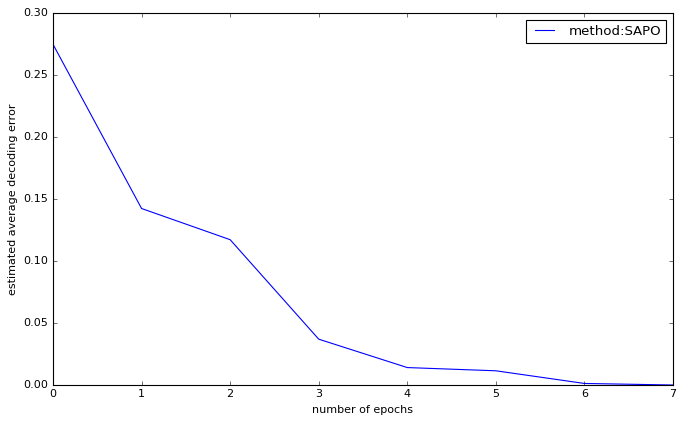

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
# import the module containing training workflow
# we use only 100 sequences for demonstration
# to go through the whole file simply omit passing the num_seqs keyword argument
num_seqs = 100
from train_bioner_workflow import *
optimization_options = {"method" : "SAPO",
                        "num_epochs":15,
                        'shuffle_seq':True,
                        "tolerance":1e-6
                        }
  
     
# demonstrate training using only 100 sequences from the both the training and test file
model_dir = run_training(optimization_options, template_config, num_seqs=num_seqs)

# using all sequences from the both the training and test file
# model_dir = run_training(optimization_options, template_config)

def plot_avg_decodingerror(model_dir):
    # plot the estimated average decoding error during training phase
    avg_decerror = ReaderWriter.read_data(os.path.join(model_dir, 'avg_decodingerror_training'))
    plt.plot(avg_decerror[1:], label="method:{}".format(optimization_options['method']))
    plt.legend(loc='upper right')
    plt.xlabel('number of epochs')
    plt.ylabel('estimated average decoding error')
    
plot_avg_decodingerror(model_dir)


# 3. Trained model evaluation

To evaluate the performance of the trained model, we will use the <code class="pseq_code">evalIOB2.pl</code> script provided by the <a href="http://www.nactem.ac.uk/tsujii/GENIA/ERtask/report.html">BioNLP/NLPBA 2004 task</a> organizers. The returned directory for the trained model will have the following structure:

<pre style="font-size:0.8em;">
├── avg_loglikelihood_training
├── crf_training_log.txt
├── decoding_seqs
│   ├── test_fold_0.txt
│   ├── train_fold_0.txt
├── model_parts
│   ├── class_desc.txt
│   ├── FE_templateX
│   ├── FE_templateY
│   ├── MR_L
│   ├── MR_modelfeatures
│   ├── MR_modelfeaturescodebook
│   ├── MR_Ycodebook
│   ├── weights
</pre>

The main parts of the model are found under the <code class="pseq_code">model_parts</code> folder. The decoded sequences using the trained model are found under <code class="pseq_code">decoding_seqs</code> folder. In that folder, we have the decoding of the training and test files. We evaluate the performance of the trained model by passing those files to the <code class="pseq_code">evalIOB2.pl</code> script (<a href="#bioner_evalmodel">as in this code snippet</a>).


<a id="bioner_evalmodel"></a>

In [ ]:
# evaluate model on the training data
decoded_training_file = os.path.join(model_dir, 'decoding_seqs', 'train_fold_0.txt')
!./evalIOB2.pl $decoded_training_file Genia4ERtask1.iob2
# evaluate model on test data set
decoded_test_file = os.path.join(model_dir, 'decoding_seqs', 'test_fold_0.txt')
!./evalIOB2.pl $decoded_test_file Genia4EReval1.iob2


# 4. Using BioNER tagger (i.e. trained model)

In this section, we demonstrate how to revive a previously trained model for bio-medical named entity recognition using <a href="http://www.nactem.ac.uk/tsujii/GENIA/ERtask/report.html">BioNLP/NLPBA 2004 dataset</a>.
<br/>
As a reminder, the trained model (including its components) are found under <code class="pseq_code">trained_models </code>folder that has the following structure:
<pre style="font-size:0.8em;">
├── trained_models
│   ├── 2017_1_8-1_33_7_459162
│   │   ├── eval_model
│   │   │   ├── decoded_test_beamsize_11.txt
│   │   │   ├── evalIOB2.pl
│   │   │   ├── Genia4EReval1.iob2
│   │   ├── readme.rst
│   │   ├── crf_training_log.txt
│   │   ├── model_parts
│   │   │   ├── class_desc.txt
│   │   │   ├── MR_L
│   │   │   ├── MR_modelfeatures
│   │   │   ├── MR_Ycodebook
│   │   │   ├── FE_templateY
│   │   │   ├── MR_modelfeaturescodebook_old
│   │   │   ├── FE_templateX
│   │   │   ├── weights
│   │   │   ├── MR_modelfeaturescodebook

</pre>

## 4.1 Reviving trained model (BioNER)

To use/revive our trained model we use <code class="pseq_function">revive_learnedmodel(args)</code> function that takes:
<ul><li>the path/directory to the trained model</li>
<li>the attribute extractor class (i.e. <code class="pseq_class">BioNERAttributeExtractor</code> class)</li>
</ul>

Looking again to the directory tree:
<pre style="font-size:0.8em;">
├── trained_models
│   ├── 2017_1_8-1_33_7_459162
│   │   ├── eval_model
│   │   │   ├── decoded_test_beamsize_11.txt
│   │   │   ├── evalIOB2.pl
│   │   │   ├── Genia4EReval1.iob2
│   │   ├── readme.rst
│   │   ├── crf_training_log.txt
│   │   ├── model_parts
│   │   │   ├── class_desc.txt
│   │   │   ├── MR_L
│   │   │   ├── MR_modelfeatures
│   │   │   ├── MR_Ycodebook
│   │   │   ├── FE_templateY
│   │   │   ├── MR_modelfeaturescodebook_old
│   │   │   ├── FE_templateX
│   │   │   ├── weights
│   │   │   ├── MR_modelfeaturescodebook
</pre>
The folder <code class="pseq_code">2017_1_8-1_33_7_459162</code> under <code class="pseq_code">trained_models</code> folder represents the path to our trained model.

In [25]:
# we get the trained model parts directory -- check the tree path in the cell above
trained_model_dir = os.path.join(project_dir, 'trained_models')
# loading the trained model
crf_m = revive_learnedmodel(os.path.join(trained_model_dir, '2017_1_8-1_33_7_459162'), BioNERAttributeExtractor)

After we have revived our model, we need sentences to decode. We will use the test dataset we already procecessed under the dataset directory. Just as a reminder, the tree path is:
<pre style="font-size:0.8em">
├── dataset
│   ├── original
│   │   ├── training
│   │   │   ├── Genia4ERtask1.iob2
│   │   │   ├── sampletest1.iob2
│   │   ├── test
│   │   │   ├── Genia4EReval1.raw
│   │   │   ├── Genia4EReval1.iob2
│   ├── test.txt
│   ├── train.txt
</pre>

This is an excerpt of the processed test file (i.e test.txt):
<pre style="font-size:0.8em">
w	pos	chunk	bio_ner
Number	NN	B-NP	O
of	IN	B-PP	O
glucocorticoid	NN	B-NP	B-protein
receptors	NNS	I-NP	I-protein
in	IN	B-PP	O
lymphocytes	NNS	B-NP	B-cell_type
and	CC	O	O
their	PRP$	B-NP	O
sensitivity	NN	I-NP	O
to	TO	B-PP	O
hormone	NN	B-NP	O
action	NN	I-NP	O
.	.	O	O

The	DT	B-NP	O
study	NN	I-NP	O
demonstrated	VBD	B-VP	O
a	DT	B-NP	O
decreased	VBN	I-NP	O
level	NN	I-NP	O
of	IN	B-PP	O
glucocorticoid	NN	B-NP	B-protein
receptors	NNS	I-NP	I-protein
(	(	O	O
GR	NN	B-NP	B-protein
)	)	O	O
in	IN	B-PP	O
peripheral	JJ	B-NP	B-cell_type
blood	NN	I-NP	I-cell_type
lymphocytes	NNS	I-NP	I-cell_type
from	IN	B-PP	O
hypercholesterolemic	JJ	B-NP	O
subjects	NNS	I-NP	O
,	,	O	O
and	CC	O	O
an	DT	B-NP	O
elevated	JJ	I-NP	O
level	NN	I-NP	O
in	IN	B-PP	O
patients	NNS	B-NP	O
with	IN	B-PP	O
acute	JJ	B-NP	O
myocardial	JJ	I-NP	O
infarction	NN	I-NP	O
.	.	O	O

In	IN	B-PP	O
the	DT	B-NP	O
lymphocytes	NNS	I-NP	B-cell_type
with	IN	B-PP	O
a	DT	B-NP	O
high	JJ	I-NP	O
GR	NN	I-NP	B-protein
number	NN	I-NP	O
,	,	O	O
dexamethasone	NN	B-NP	O
inhibited	VBD	B-VP	O
[	(	O	O
3H	NN	O	O
]	)	O	O
-thymidine	NN	B-NP	O
and	CC	O	O
[	(	O	O
3H	NN	B-NP	O
]	)	O	O
-acetate	JJ	B-NP	O
incorporation	NN	I-NP	O
into	IN	B-PP	O
DNA	NN	B-NP	O
and	CC	I-NP	O
cholesterol	NN	I-NP	O
,	,	O	O
respectively	RB	B-ADVP	O
,	,	O	O
in	IN	B-PP	O
the	DT	B-NP	O
same	JJ	I-NP	O
manner	NN	I-NP	O
as	IN	B-PP	O
in	IN	B-PP	O
the	DT	B-NP	O
control	JJ	I-NP	B-cell_type
cells	NNS	I-NP	I-cell_type
.	.	O	O
</pre>

To read the file, we will use <code class="pseq_class">DataFileParser</code> class in the <code class="pseq_code">utilities</code> module. 

In [26]:
from pyseqlab.utilities import DataFileParser
# initialize a data file parser
dparser = DataFileParser()
# provide the options to parser such as the header info, the separator between words and if the y label is already existing
# main means the header is found in the first line of the file
header = "main"
# y_ref is a boolean indicating if the label to predict is already found in the file
y_ref = True
# spearator between the words/observations
column_sep = "\t"
seqs = []
for seq in dparser.read_file(os.path.join(project_dir, 'dataset', 'test.txt'), header, y_ref=y_ref, column_sep = column_sep):
    seqs.append(seq)
    
# printing one sequence for display
print(seqs[0])
print("number of parsed sequences is: ", len(seqs))

Y sequence:
 ['O', 'O', 'B-protein', 'I-protein', 'O', 'B-cell_type', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
X sequence:
 {1: {'w': 'Number', 'chunk': 'B-NP', 'pos': 'NN'}, 2: {'w': 'of', 'chunk': 'B-PP', 'pos': 'IN'}, 3: {'w': 'glucocorticoid', 'chunk': 'B-NP', 'pos': 'NN'}, 4: {'w': 'receptors', 'chunk': 'I-NP', 'pos': 'NNS'}, 5: {'w': 'in', 'chunk': 'B-PP', 'pos': 'IN'}, 6: {'w': 'lymphocytes', 'chunk': 'B-NP', 'pos': 'NNS'}, 7: {'w': 'and', 'chunk': 'O', 'pos': 'CC'}, 8: {'w': 'their', 'chunk': 'B-NP', 'pos': 'PRP$'}, 9: {'w': 'sensitivity', 'chunk': 'I-NP', 'pos': 'NN'}, 10: {'w': 'to', 'chunk': 'B-PP', 'pos': 'TO'}, 11: {'w': 'hormone', 'chunk': 'B-NP', 'pos': 'NN'}, 12: {'w': 'action', 'chunk': 'I-NP', 'pos': 'NN'}, 13: {'w': '.', 'chunk': 'O', 'pos': '.'}}
----------------------------------------
number of parsed sequences is:  3856


## 4.2 Decoding method

Then, we decide the decoding options for our model to use. The main method for decoding is <code class="pseq_method">decode_seqs(decoding_method, out_dir, **kwargs)</code> that takes two arguments and multiple keyword arguments. 
<br/>

The obligatory arguments are:
<ol>
<li>
<code class="pseq_args">decoding_method</code>: string representing the decoding method such as <code class="pseq_code">'viterbi'</code>
</li>
<li>
<code class="pseq_args">output_dir</code>: string, the output directory representing the path where the parsing would take place
</li>
</ol>

For the keyword arguments, the main ones to specify are:
<ul>
<li>
<code class="pseq_args">seqs</code>: the list of sequences we already parsed/read from the text file we need to label
</li>
<li>
<code class="pseq_args">file_name</code>: the name of the file where decoded sequences will be written to (it is optional)
</li>
<li>
<code class="pseq_args">sep</code>: the separator between the columns/observations when writing decoded sequences to the specified file using <code class="pseq_args">file_name</code> keyword argument
</li>
</ul>

In [27]:
decoding_method = 'viterbi'
output_dir = os.path.join(project_dir, 'tutorials')
sep = "\t"
# decode sequences
seqs_decoded = crf_m.decode_seqs(decoding_method, output_dir, seqs= seqs, file_name = 'tutorial_seqs_decoding.txt', sep=sep)

identifying model active features -- processed seqs:  1
identifying model active features -- processed seqs:  2
identifying model active features -- processed seqs:  3
identifying model active features -- processed seqs:  4
identifying model active features -- processed seqs:  5
identifying model active features -- processed seqs:  6
identifying model active features -- processed seqs:  7
identifying model active features -- processed seqs:  8
identifying model active features -- processed seqs:  9
identifying model active features -- processed seqs:  10
identifying model active features -- processed seqs:  11
identifying model active features -- processed seqs:  12
identifying model active features -- processed seqs:  13
identifying model active features -- processed seqs:  14
identifying model active features -- processed seqs:  15
identifying model active features -- processed seqs:  16
identifying model active features -- processed seqs:  17
identifying model active features -- pro

The decoded sequences will be found under the <code class="pseq_code">tutorials</code> directory (i.e. current directory) under <code class="pseq_code">decoding_seqs</code> folder.
<pre style="font-size:0.8em;">
|---tutorials
|      |---decoding_seqs
|      |             |---tutorial_seqs_decoding.txt
</pre>
The <code class="pseq_code">tutorial_seqs_decoding.txt</code> file will follow the same template/format of the <code class="pseq_code">test.txt</code> file we already parsed earlier, but this time with additional column that contains our model's predictions.
We can check our model performance by using  the <code class="pseq_code">evalIOB2.pl</code> script provided by the <a href="http://www.nactem.ac.uk/tsujii/GENIA/ERtask/report.html">BioNLP/NLPBA 2004 task</a> organizers.

In [10]:
# evaluate model on test data set
new_decseqs_file = os.path.join(tutorials_dir, 'decoding_seqs','tutorial_seqs_decoding.txt')
!./evalIOB2.pl $new_decseqs_file Genia4EReval1.iob2


                              Biomedical Entity Recognition Performance (Genaral)                                         
                                                                                         number(recall/precision/f-score) 
+------------------+---------------------------------+---------------------------------+---------------------------------+
|                  |          complete match         |       right boundary match      |       left boundary match       |
+------------------+---------------------------------+---------------------------------+---------------------------------+
|  protein  (5067) | 4020 (79.34% / 67.76% / 73.09%) | 4395 (86.74% / 74.08% / 79.91%) | 4283 (84.53% / 72.19% / 77.87%) |
+------------------+---------------------------------+---------------------------------+---------------------------------+
|    DNA    (1056) |  710 (67.23% / 70.93% / 69.03%) |  796 (75.38% / 79.52% / 77.39%) |  736 (69.70% / 73.53% / 71.56%) |
+---------------

Our model achieves overall F1-measure equal to 71.41 %<br/>

Can we do better? To answer this question, we need to explore and experiment with different feature templates and attributes for training a model. We leave this as an exercise for the readers ... :)


# 5. Literature and references

Kim, J.-D., Ohta, T., Tsuruoka, Y., Tateisi, Y., & Collier, N. (2004). Introduction to the Bio-entity Recognition Task at JNLPBA. Proceedings of the International Joint Workshop on Natural Language Processing in Biomedicine and Its Applications, 70–75. doi:10.3115/1567594.1567610

Sun, X. (2015). Towards Shockingly Easy Structured Classification: A Search-based Probabilistic Online Learning Framework. Retrieved from http://arxiv.org/abs/1503.08381